# Breath Pattern Modeling and Pattern Recognition for Health Anomaly Detection 

This notebook provides an overview of our source code and serves as a practical guide for using it.
We have added comprehensive docstrings to all classes and methods to ensure clarity and ease of use. For detailed information on specific functions or parameters, please refer to the respective docstrings. Please make sure that you have installed all the necessary packages in the `requirements.txt`.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from ipywidgets import interact, FloatSlider, IntSlider, Layout
import joblib
import torch
import torch.nn as nn
import torch.optim as optim

os.environ["PYTHONWARNINGS"] = "ignore::UserWarning" 

slider_layout = Layout(width='400px')
style = {'description_width': '150px'}

## Transmitter

The `Transmitter` is responsible for generating synthetic breathing patterns. These waveforms simulate the temporal flow dynamics of human respiration and can later be distorted (Channel) and classified (Receiver). You can choose different waveform types or even define your own. The base waveform is a sinusoidal function To use the `Transmitter`, import the class and create an instance:

In [2]:
from breath_modeling.core.transmitter import Transmitter

# create a transmitter object
tx = Transmitter()

The `Transmitter` module provides several methods for generating characteristic breathing signals. Each method corresponds to a specific physiological breathing pattern (e.g., Eupnea, Apnea, Cheyne-Stokes) and supports waveform customization via parameters.

To create a signal, call: `tx.<pattern_name>(t)` where t is the time vector.

You can optionally adjust the pattern using:
- `amplitude_factor`: scales the signal amplitude 
- `frequency_factor`: modifies the base frequency 
- `signal_type`: selects the waveform type ('sinus', 'square', 'sawtooth', etc.) 

Additional pattern-specific parameters can be passed via keyword arguments (`**kwargs`). For example, the `cheyne_stokes()` method allows configuring cycle duration and depth modulation.

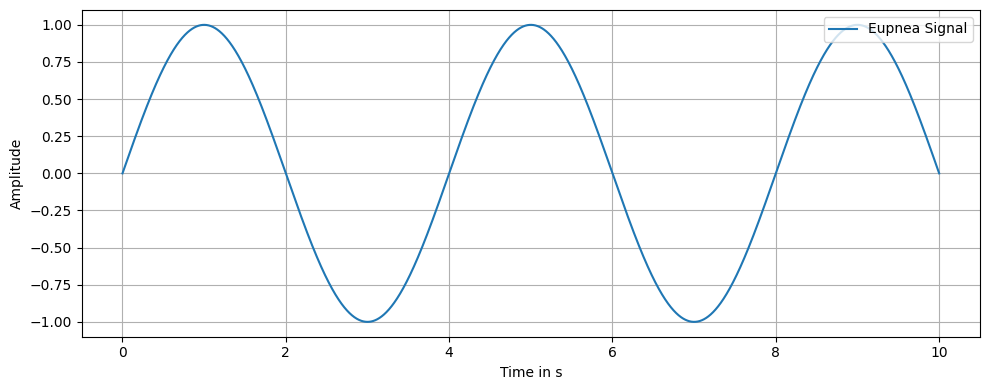

In [3]:
# time vector
fs = 1000  
duration = 10 
t = np.linspace(0, duration, int(fs * duration))

eupnea_signal = tx.eupnea(t)
sighing_signal = tx.sighing(t)
tachypnea_signal = tx.tachypnea(t)
kussmaul_signal = tx.kussmaul(t)
cheyne_stokes_signal = tx.cheyne_stokes(t)
apnea_signal = tx.apnea(t)

# plot
plt.figure(figsize=(10, 4))
plt.plot(t, eupnea_signal, label='Eupnea Signal', color='tab:blue')
plt.xlabel('Time in s')
plt.ylabel('Amplitude')
plt.grid()
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In order to apply the channel impulse response model from the literature, we need to convert the breathing signal into a molecular representation. Use the following method: `tx.molecular_output(<pattern_name>, scale=1)`

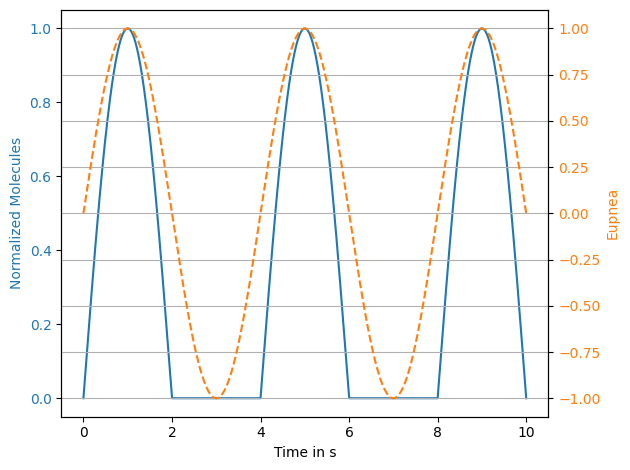

In [4]:
molecules = tx.molecular_output(eupnea_signal, scale=1)

# plot
fig, ax1 = plt.subplots()
ax1.plot(t, molecules, color='tab:blue', label='Molecule emission')
ax1.set_xlabel('Time in s')
ax1.set_ylabel('Normalized Molecules', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax1.twinx()
ax2.plot(t, eupnea_signal, color='tab:orange', linestyle='--', label='Eupnea signal')
ax2.set_ylabel('Eupnea', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
fig.tight_layout()
plt.grid()
plt.show()

The `Transmitter` also supports adding realistic signal distortions and noise, reflecting sensor imperfections or environmental variability. Available methods include:
- `add_noise`: adds white Gaussian noise
- `baseline_drift`: simulates low-frequency drift due to sensor instability
- `amplitude_distortions`: introduces nonlinear amplitude variations
- `motion_artifacts`: mimics signal interruptions caused by movement

These methods can be combined with any generated breathing pattern to simulate realistic sensing conditions.

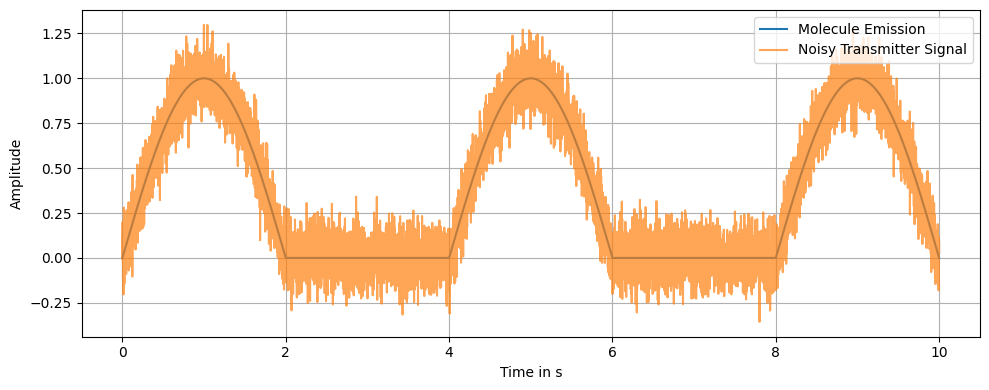

In [5]:
noisy_tx_signal = tx.add_noise(molecules, noise_type='gaussian', std=0.1)

# plot
plt.figure(figsize=(10, 4))
plt.plot(t, molecules, label='Molecule Emission', color='tab:blue')
plt.plot(t, noisy_tx_signal, label='Noisy Transmitter Signal', color='tab:orange', alpha=0.7)  
plt.xlabel('Time in s')
plt.ylabel('Amplitude')
plt.grid()
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

## Channel

The `Channel` class models the physical transmission of exhaled molecules from the transmitter to the receiver. It captures key transport mechanisms such as diffusion and advection through a closed-form Channel Impulse Response (CIR).

To approximate realistic environmental conditions, the channel module also includes a wide range of configurable noise and distortion mechanisms. These simulate effects like:
- Signal attenuation due to distance, material, or airflow,
- Amplitude-dependent noise and noise floors,
- Temporal artifacts such as jitter, warping, and global delay,
- Sample loss and cross-talk from external signals.

Each of these can be activated and adjusted using keyword arguments in the corresponding methods. 

In [6]:
from breath_modeling.core.channel import Channel

# create a channel object
ch = Channel()

To simulate the transport of molecules from the transmitter to the receiver, we model the CIR using a one-dimensional advection-diffusion formulation:
$$
h(t) = \frac{M}{\sqrt{4 \pi D t}} \exp\left( -\frac{(d - v t)^2}{4 D t} \right), \quad t > 0
$$
where:
- $M$: number of emitted molecules
- $D$: diffusion coefficient
- $d$: distance between transmitter and receiver
- $v$: advection velocity
- $t$: time

First create the CIR using `ch.cir()`:

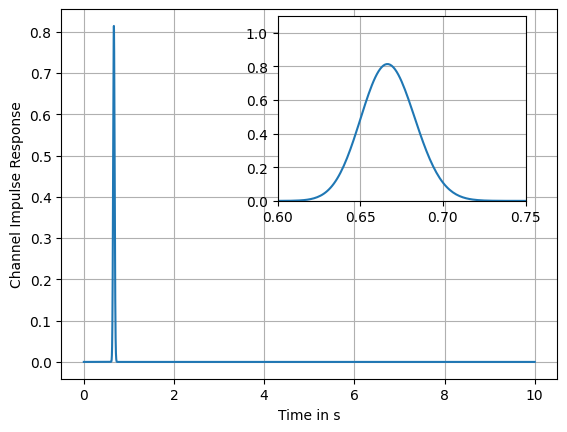

In [7]:
number_of_molecules = 1         
diffusion_coefficient = 0.18    # in cm^2/s
distance_tx_rx = 20             # in cm
velocity = 30                   # in cm/s
cir = ch.cir(t, M=number_of_molecules, D=diffusion_coefficient, r=distance_tx_rx, v=velocity)

# plot
fig, ax = plt.subplots()
ax.plot(t, cir, color='tab:blue', label='CIR')
ax.set_xlabel('Time in s')
ax.set_ylabel('Channel Impulse Response')
ax.grid()
axins = inset_axes(ax, width="50%", height="50%", bbox_to_anchor=(-0.05, 0, 1, 1), bbox_transform=ax.transAxes)
axins.plot(t, cir, color='tab:blue')
x1, x2 = 0.6, 0.75
y1, y2 = 0, 1.1
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.grid()
plt.show()
plt.close(fig)

Since this framework is designed to simulate a variety of scenarios, we encourage you to experiment with the diffusion coefficient and advection velocity to observe their impact on the CIR.

In [8]:
def plot_cir(number_of_molecules=1, diffusion_coefficient=0.0959, distance_tx_rx=225, velocity=190):

    cir = ch.cir(t, M=number_of_molecules, D=diffusion_coefficient, r=distance_tx_rx, v=velocity)

    # plot
    plt.figure(figsize=(15, 4))
    plt.plot(t, cir)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Channel Impulse Response (CIR)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

interact(plot_cir,
         number_of_molecules=IntSlider(min=1, max=10, step=1, description='Molecules', style=style, layout=slider_layout),
         diffusion_coefficient=FloatSlider(min=0.01, max=200, step=0.001, description='Diffusion Coefficient', style=style, layout=slider_layout),
         distance_tx_rx=FloatSlider(min=0, max=300, step=5, description='Distance Tx-Rx', style=style, layout=slider_layout),
         velocity=FloatSlider(min=0, max=100, step=1, description='Velocity', style=style, layout=slider_layout));

interactive(children=(IntSlider(value=1, description='Molecules', layout=Layout(width='400px'), max=10, min=1,…

To apply the CIR to a synthetic breathing signal $x_{\text{tx}}(t)$ and use convolution:
$$
y(t) = x_{\text{tx}}(t) * h(t)
$$
Since the convolution is performed in discrete time, the result must be scaled by the sampling frequency `1/fs` to maintain correct signal magnitude:

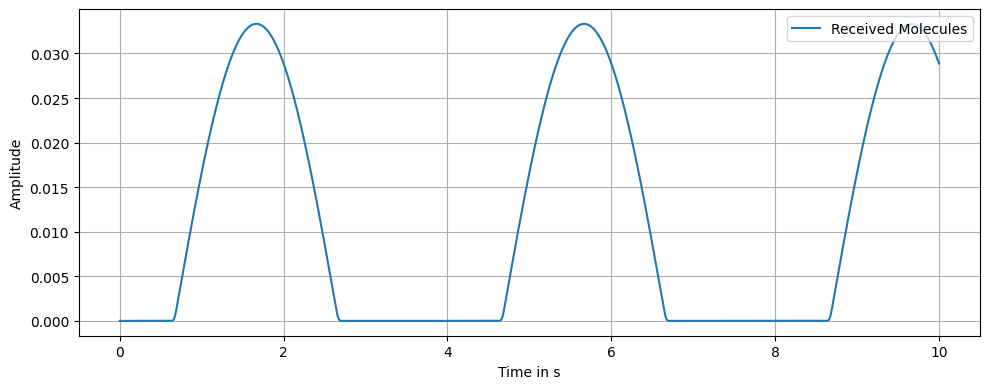

In [9]:
received_molecules = np.convolve(molecules, cir, mode='full')[:len(t)] * 1/fs

plt.figure(figsize=(10, 4))
plt.plot(t, received_molecules, label='Received Molecules')  
plt.xlabel('Time in s')
plt.ylabel('Amplitude')
plt.grid()
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
plt.close()

You can interactively explore different noise and distortion types by adjusting parameters. Let’s start with signal attenuation.
The signal amplitude is uniformly dampened by factors such as the distance between transmitter and receiver, the channel material, opposing airflow, the angle of airflow incidence, and physical obstacles. In addition, we introduced an exponential decay, controlled by a `decay rate` parameter, which gradually attenuates the signal over time.

In [10]:
def plot_attenuation(distance=1.0, material_factor=0.95, decay_rate=0.01, angle=0.0, airflow=0.0, obstacle_size=0.0, obstacle_density=0.0):

    attenuated = ch.attenuation(molecules, t,
                                 distance=distance,
                                 material_factor=material_factor,
                                 decay_rate=decay_rate,
                                 angle_of_incidence=angle,
                                 airflow_speed=airflow,
                                 obstacle_size=obstacle_size,
                                 obstacle_density=obstacle_density)

    plt.figure(figsize=(15, 4))
    plt.plot(t, molecules, label='Original Signal', alpha=0.4)
    plt.plot(t, attenuated, label='Attenuated Signal', linewidth=2)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Signal Attenuation')
    plt.grid(True)
    plt.legend(loc = "upper right")
    plt.tight_layout()
    plt.show()

interact(plot_attenuation,
         distance=FloatSlider(min=0.0, max=5.0, step=0.1, description='Distance', style=style, layout = slider_layout),
         material_factor=FloatSlider(min=0.0, max=1.0, step=0.05, value=1.0, description='Material', style=style, layout = slider_layout),
         decay_rate=FloatSlider(min=0.0, max=0.1, step=0.005, description='Decay Rate', style=style, layout = slider_layout),
         angle=FloatSlider(min=0.0, max=90.0, step=1.0, description='Angle', style=style, layout = slider_layout),
         airflow=FloatSlider(min=0.0, max=2.0, step=0.1, description='Airflow', style=style, layout = slider_layout),
         obstacle_size=FloatSlider(min=0.0, max=1.0, step=0.05, description='Obstacle Size', style=style, layout=slider_layout),
         obstacle_density=FloatSlider(min=0.0, max=1.0, step=0.05, description='Obstacle Density', style=style, layout = slider_layout));

interactive(children=(FloatSlider(value=0.0, description='Distance', layout=Layout(width='400px'), max=5.0, st…

Now to the most important noise type:
We first allow for a basic noise floor, which adds uniform background noise to the entire signal. However noise is not equally distributed in real- world systems. Instead, it increases with signal amplitude, known as amplitude-dependent noise. This models physical effects such as turbulence or scattering, and becomes stronger with increasing transmission distance.

In [11]:
def plot_noise(distance=1.0, base_strength = 0.1, noise_floor= 0.0, noise_type='gaussian'):

    noisy_signal = ch.amplitude_dependent_noise(received_molecules, noise_type=noise_type, distance=distance, base_strength=base_strength)
    noisy_signal = ch.noise_floor(noisy_signal, noise_floor=noise_floor)

    plt.figure(figsize=(15, 4))
    plt.plot(t, received_molecules, label="Original Signal", alpha=0.4)
    plt.plot(t, noisy_signal, label=f"Noisy Signal ({noise_type})", linewidth=1)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Noise Influence")
    plt.grid(True)
    plt.legend(loc = "upper right")
    plt.tight_layout()
    plt.show()

interact(
    plot_noise,
    distance=FloatSlider(min=0.0, max=20.0, step=0.1, description="Distance", style=style, layout=slider_layout),
    noise_type=['gaussian', 'uniform'],
    base_strength=FloatSlider(min=0.0, max=0.002, step=0.0001, value=0.001, description='Base Strength', style=style, layout=slider_layout, readout_format='.4f'),
    noise_floor=FloatSlider(min=0.0, max=0.01, step=0.001, value=0.0, description='Noise Floor', style=style, layout=slider_layout)
);

interactive(children=(FloatSlider(value=0.0, description='Distance', layout=Layout(width='400px'), max=20.0, s…

Next are the temporal distortions. We implemented jitter and temporal warping to simulate irregular sampling intervals, nonlinear timing shifts, or local stretching of the signal. On top of that, there’s a global delay parameter that shifts the entire signal in time, and a sample drop probability that reflects the idea of molecules randomly being lost. Since our virtual channel is unbounded and molecules can simply drift away.

In [12]:
def plot_temporal_effects(jitter_std=0.001, time_warp_strength=0.01, delay_sec=0.0, drop_prob=0.0, drop_block=1):

    delayed = ch.global_delay(received_molecules, delay=delay_sec, delay_in_seconds=True, roll=False)
    jittered = ch.sampling_jitter(delayed, jitter_std=jitter_std)
    warped = ch.time_warping(jittered, time_warp_strength=time_warp_strength)
    dropped = ch.dropped_samples(warped, drop_prob=drop_prob, drop_block=drop_block)

    plt.figure(figsize=(15, 4))
    plt.plot(t, received_molecules, label='Original', alpha=0.3)
    plt.plot(t, dropped, label='Temporal distorted Signal')
    plt.title("Temporal Distortions")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

interact(
    plot_temporal_effects,
    jitter_std=FloatSlider(min=0.0, max=0.2, step=0.001, description='Jitter Std', style=style, layout=slider_layout),
    time_warp_strength=FloatSlider(min=0.0, max=20, step=1, description='Warp Strength', style=style, layout=slider_layout),
    delay_sec=FloatSlider(min=0.0, max=10, step=0.1, description='Global Delay', style=style, layout=slider_layout),
    drop_prob=FloatSlider(min=0.0, max=1, step=0.01, description='Drop Prob.', style=style, layout=slider_layout),
    drop_block=IntSlider(min=1, max=100, step=1, description='Drop Block', style=style, layout=slider_layout)
);

interactive(children=(FloatSlider(value=0.0, description='Jitter Std', layout=Layout(width='400px'), max=0.2, …

Lastly, we modeled cross-talk and environmental interference. These simulate foreign influences like wind or overlapping signals from nearby sources. The result is a signal that can exhibit characteristics similar to amplitude or frequency modulation – where our clean breathing waveform becomes distorted by oscillating interference components.

In [13]:
def plot_cross_talk_effects(wind_strength=0.0, wind_freq=0.5, wind_phase=0.0, foreign_strength=0.0, foreign_delay=0.0, foreign_freq=0.25, shift_freq=0.0):

    crosswind_signal = ch.cross_wind(received_molecules, strength=wind_strength, frequency=wind_freq, phase=wind_phase)
    foreign_signal = ch.add_foreign_signal(crosswind_signal, t, foreign_signal=None, strength=foreign_strength, delay=foreign_delay, foreign_freq=foreign_freq, shift_freq=shift_freq)

    plt.figure(figsize=(15, 4))
    plt.plot(t, received_molecules, label="Original", alpha=0.3)
    plt.plot(t, foreign_signal, label="Modified Signal", linewidth=1.5)
    plt.title("Cross-talk & Environmental Interference Effects")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.legend(loc = "upper right")
    plt.tight_layout()
    plt.show()

interact(
    plot_cross_talk_effects,
    wind_strength=FloatSlider(min=0.0, max=0.050, step=0.01, description="Wind Strength", style=style, layout=slider_layout),
    wind_freq=FloatSlider(min=0.1, max=2.0, step=0.1, description="Wind Freq", style=style, layout=slider_layout),
    wind_phase=FloatSlider(min=0.0, max=2*np.pi, step=0.1, description="Wind Phase", style=style, layout=slider_layout),
    foreign_strength=FloatSlider(min=0.0, max=0.01, step=0.005, description="Foreign Signal", style=style, layout=slider_layout),
    foreign_delay=FloatSlider(min=0.0, max=1.0, step=0.0001, description="Foreign Delay", style=style, layout=slider_layout),
    foreign_freq=FloatSlider(min=0.1, max=2.0, step=0.1, description="Foreign Freq", style=style, layout=slider_layout),
    shift_freq=FloatSlider(min=0.0, max=2.0, step=0.1, description="Modulation", style=style, layout=slider_layout)
);

interactive(children=(FloatSlider(value=0.0, description='Wind Strength', layout=Layout(width='400px'), max=0.…

## Receiver

The `Receiver` can optionally apply additional noise to the input signal to simulate more realistic conditions. To perform pattern recognition, an instance of the Receiver must be created and the corresponding model must be loaded. Classical machine learning models are used for single-pattern classification, while deep learning models are used for sequence-based classification.

In [14]:
from breath_modeling.core.receiver import Receiver

/Users/leon/.pyenv/versions/tkn_breath_modeling/lib/python3.13/site-packages/tsfresh/__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


The following example shows how the classical ML model can be used to classify a sequence. A sample sequence is passed to the `Receiver` for prediction.

/Users/leon/.pyenv/versions/tkn_breath_modeling/lib/python3.13/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(
/Users/leon/.pyenv/versions/tkn_breath_modeling/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


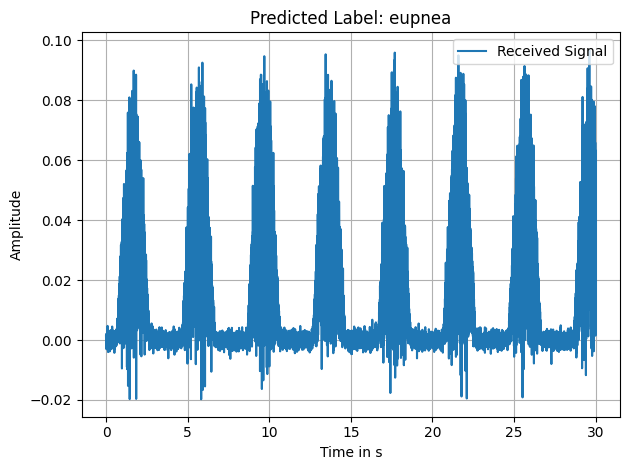

In [15]:
# time vector
fs = 1000  
duration = 30 
t = np.linspace(0, duration, int(fs * duration))

signal = tx.eupnea(t) # try different signals: tx.apnea(t), tx.sighing(t), tx.kussmauk(t) or tx.cheyne_stokes(t)
molecules = tx.molecular_output(signal, scale=1)
cir = ch.cir(t, M=1, D=0.18, r=20, v=30)
cir = cir / np.max(cir)
received_signal = np.convolve(molecules, cir, mode='full')[:len(t)] * 1/fs
received_signal = ch.noise_floor(received_signal, noise_floor=0.001)
received_signal = ch.amplitude_dependent_noise(received_signal, distance=20, base_strength=0.001)

rx = Receiver(model_type="rf")
label = rx.predict_signal_rf(received_signal, fs=fs)

plt.plot(t, received_signal, label='Received Signal')
plt.title(f"Predicted Label: {label}")
plt.xlabel('Time in s')
plt.ylabel('Amplitude')
plt.grid()
plt.legend(loc='upper right')
plt.tight_layout()

To analyze a full breathing sequence, a signal can be loaded and classified using a pretrained model. The system supports multiple model types, including CNN, and BiLSTM. By changing the `model_type` in the Receiver, you can experiment with different architectures and compare their predictions. The BiLSTM works the best.

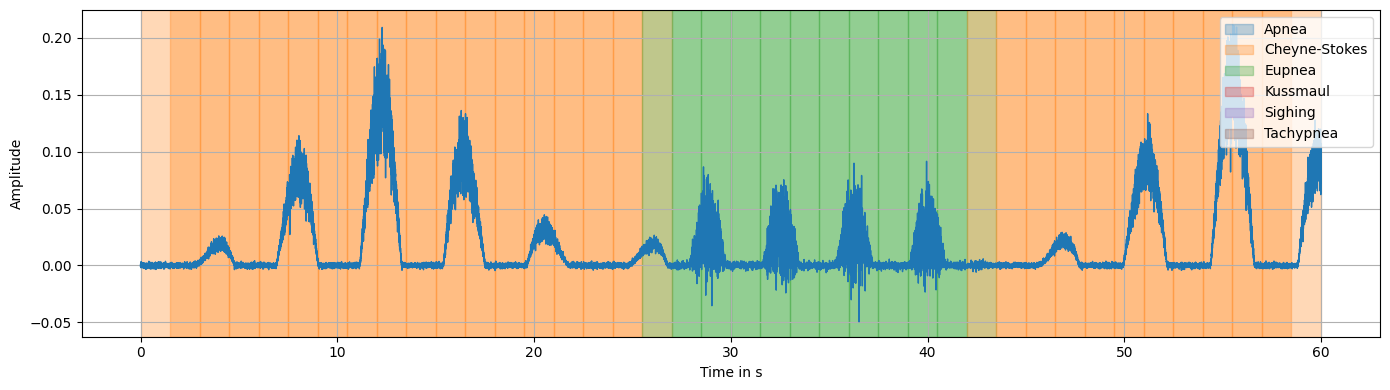

In [ ]:
sequences = np.load(os.getcwd() + "/src/breath_modeling/model/dataset/sequences/sequence_003.npy")

fs = 500
window_size = 3.0
stride = 1.5

rx = Receiver(model_type="bilstm") # Change to "cnn", "bilstm"
pred_labels, starts = rx.predict_window(sequences, fs=fs, window_size=window_size, stride=stride)

# plot
t = np.arange(len(sequences)) / fs
label_colors = {l.capitalize().replace('Cheyne_stokes', 'Cheyne-Stokes'): plt.cm.tab10(i) for i, l in enumerate(rx.label_encoder.classes_)}
pred_labels_cap = [l.capitalize().replace('Cheyne_stokes', 'Cheyne-Stokes') for l in pred_labels]

plt.figure(figsize=(14, 4))
plt.plot(t, sequences, label="Signal", linewidth=1)
for i, start in enumerate(starts):
    plt.axvspan(start, start + window_size, color=label_colors[pred_labels_cap[i]], alpha=0.3)

plt.xlabel("Time in s")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend(handles=[
    plt.Rectangle((0, 0), 1, 1, color=c, label=l, alpha=0.3) for l, c in label_colors.items()
], loc="upper right")
plt.tight_layout()
plt.show()

### Model

If the model needs to be adjusted or retrained, the dataset can be regenerated or modified accordingly. For this purpose, a script named `create_dataset.py` is placed in the `src/breath_modelling/model` directory. This script simulates various breathing patterns as time series and generates both individual samples and longer sequences using sliding windows, along with the corresponding labels.

Configuration

The setup includes:
- Sampling parameters such as sampling rate (FS) and sequence duration
- System parameters like distance, molecule velocity, and diffusion coefficient
- Variation parameters (amplitude, frequency, timing) to introduce realistic signal distortions
- Noise characteristics and baseline signal strength
- Windowing settings for sequence segmentation

Dataset Creation
1.	Sample dataset: For each breathing pattern (e.g., eupnea, apnea, etc.), individual signal samples of fixed duration are generated, including configurable signal variation and noise.
2.	Sequence dataset: Longer mixed signal sequences are synthesized by combining multiple patterns. These are segmented and labeled using a sliding window approach.

The resulting files include both raw signals and structured data ready for training and evaluating the classification model.

If you want to train a new model, the first step is to load the dataset using the corresponding loader function. This procedure is consistent across all model types (Random Forest, CNN, BiLSTM, etc.)

In [17]:
from breath_modeling.model.loader import load_dataset

df_long = load_dataset("random_forest", max_samples_per_pattern=100)

Now you can retrain your Random Forest and save again. This is commented out because it is computationally intensive.

In [18]:
from breath_modeling.model.train import train_random_forest

# clf, le, selected_features, (X_train, X_test, y_train, y_test) = train_random_forest(df_long)

# save model
# joblib.dump({"model": clf, "label_encoder": le, "selected_features": selected_features}, "src/breath_modeling/core/models/rf/random_forest.joblib")

The same applies to the deep learning models. Different architectures can be loaded from the architecture module and trained using the `train_model` function.

In [19]:
from breath_modeling.model.architecture import CNNClassifier, CNNBiLSTMClassifier, CNNBiLSTMBahdanauClassifier
from breath_modeling.model.train import train_model

To train a CNN model, the architecture must first be loaded, along with the corresponding optimizer and loss function. The training function is available but commented out in this example, as training can be computationally intensive.

After training, both the training and validation losses are returned for later evaluation and visualization.

In [20]:
train_loader, val_loader, le = load_dataset("cnn")

X_batch, _ = next(iter(train_loader))
input_len = X_batch.shape[1]

model = CNNClassifier(input_len=input_len, n_classes=len(le.classes_))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model, logs = train_model(model, train_loader, val_loader, criterion, optimizer, device=device, num_epochs=50, patience=7, save_path="cnn/model.pth")

For the BiLSTM model, the process is the same. The architecture is loaded from the architecture module, followed by defining the optimizer and loss function. Training can then be performed using the shared `train_model` function.

In [21]:
train_loader, val_loader, le = load_dataset("lstm")
window_len = next(iter(train_loader))[0].shape[2]

model = CNNBiLSTMClassifier(window_len=window_len, n_classes=len(le.classes_))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model, logs = train_model(model, train_loader, val_loader, criterion, optimizer, device=device, num_epochs=50, is_sequence=True, patience=7, save_path="bilstm/model.pth")x